In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_context('talk', font_scale= 1.5)
sns.set_style("white")
sns.set_context("paper")
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

In [3]:
from pyDOE import *

(array([-0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,
         2.  ,  2.25]), <a list of 11 Text yticklabel objects>)

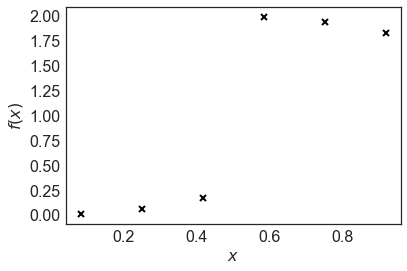

In [4]:
dim = 1
n = 6
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]
Xnorm = (X - 0.5) / 0.5
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, color='black')
ax.set_xlabel('$x$', fontsize=16)
ax.set_ylabel('$f(x)$', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

In [5]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
k.lengthscales.prior = gpflow.priors.Gamma(1, 1)
noisekern = gpflow.kernels.RBF(input_dim=1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
mean_func = gpflow.mean_functions.Constant(0)
m = hetero_gpmc.GPMCAdaptiveLengthscaleMultDim(Xnorm, Y, k, nonstat, mean_func)

In [6]:
for i in xrange(dim):
    print i
    m.kerns["ell" + str(i)].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
    m.kerns["ell" + str(i)].variance.prior = gpflow.priors.Gamma(1., 1.)
    m.mean_funcs["ell" + str(i)].c = 0.
    m.mean_funcs["ell" + str(i)].c.fixed = True 
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)
m.likelihood.variance = 1e-6
m.likelihood.variance.fixed = True

0


In [7]:
m.optimize(maxiter=50000) # start near MAP

      fun: array([-17.48245084])
 hess_inv: <15x15 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02867641,  0.0284987 ,  0.01167601,  0.00433816, -0.02325524,
        0.06647317,  0.02370785, -0.05534691,  0.04240176, -0.04860805,
        0.02957266,  0.0330744 ,  0.01156306, -0.00743492,  0.05676931])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1503
      nit: 1196
   status: 0
  success: True
        x: array([-1.17779087,  0.1745032 ,  0.04282961, -0.08301062, -0.15266541,
        0.13002271,  0.12339926, -0.03051496,  1.38192518, -0.07379435,
        0.92646654,  0.62346235, -0.17674245,  0.8912254 ,  1.83060907])

In [8]:
mcmc_samples = 1000

In [9]:
samples = m.sample(mcmc_samples, verbose=True, epsilon=0.0005, thin = 2, burn = 1000, Lmax = 20)

burn-in sampling started
Iteration:  100 	 Acc Rate:  85.0 %
Iteration:  200 	 Acc Rate:  85.0 %
Iteration:  300 	 Acc Rate:  86.0 %
Iteration:  400 	 Acc Rate:  88.0 %
Iteration:  500 	 Acc Rate:  87.0 %
Iteration:  600 	 Acc Rate:  88.0 %
Iteration:  700 	 Acc Rate:  92.0 %
Iteration:  800 	 Acc Rate:  93.0 %
Iteration:  900 	 Acc Rate:  88.0 %
Iteration:  1000 	 Acc Rate:  97.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  87.0 %
Iteration:  200 	 Acc Rate:  90.0 %
Iteration:  300 	 Acc Rate:  88.0 %
Iteration:  400 	 Acc Rate:  86.0 %
Iteration:  500 	 Acc Rate:  92.0 %
Iteration:  600 	 Acc Rate:  89.0 %
Iteration:  700 	 Acc Rate:  88.0 %
Iteration:  800 	 Acc Rate:  90.0 %
Iteration:  900 	 Acc Rate:  90.0 %
Iteration:  1000 	 Acc Rate:  84.0 %
Iteration:  1100 	 Acc Rate:  91.0 %
Iteration:  1200 	 Acc Rate:  87.0 %
Iteration:  1300 	 Acc Rate:  91.0 %
Iteration:  1400 	 Acc Rate:  82.0 %
Iteration:  1500 	 Acc Rate:  84.0 %
Iteration:  1600 	 Acc Rate:  90.0 %
Iteratio

In [10]:
xnew = np.linspace(0,1,50)[:,None]
xx = (xnew - 0.5)/0.5

In [11]:
sample_df = m.get_samples_df(samples)

In [12]:
sample_df

,adaptive_lengthscale_gp_multdim.V,adaptive_lengthscale_gp_multdim.V4,adaptive_lengthscale_gp_multdim.kern_type.lengthscales,adaptive_lengthscale_gp_multdim.kern_type.variance,adaptive_lengthscale_gp_multdim.likelihood.variance,adaptive_lengthscale_gp_multdim.mean_func.c,adaptive_lengthscale_gp_multdim.nonstat.signal_variance
0,"[[-1.2545254164], [0.241479505578], [-0.038846...","[[0.14061367042], [-0.0204008699452], [1.55221...",[0.572715822467],[1.3991876381],[1e-06],[0.0],[1.54647570913]
1,"[[-1.25545182608], [0.239211443445], [-0.03757...","[[0.139735984303], [-0.0186541717958], [1.5534...",[0.574100320063],[1.39863127007],[1e-06],[0.0],[1.54607886515]
2,"[[-1.25544288578], [0.238431824687], [-0.03791...","[[0.139428985972], [-0.0185667827069], [1.5497...",[0.576474870555],[1.39748018444],[1e-06],[0.0],[1.5501031558]
3,"[[-1.258736327], [0.226519993879], [-0.0373644...","[[0.138928655925], [-0.0179980648085], [1.5515...",[0.580083173876],[1.39572277268],[1e-06],[0.0],[1.54726050579]
4,"[[-1.25398250673], [0.224959195486], [-0.03869...","[[0.139308028622], [-0.0199929406212], [1.5527...",[0.58020988172],[1.40002448876],[1e-06],[0.0],[1.54546493796]
5,"[[-1.25496557945], [0.229874750607], [-0.03940...","[[0.138546157765], [-0.0187804485443], [1.5539...",[0.580170248015],[1.40288662144],[1e-06],[0.0],[1.54567146535]
6,"[[-1.25095918336], [0.240469365182], [-0.03705...","[[0.139122113097], [-0.020618161542], [1.54936...",[0.581887631709],[1.39531230732],[1e-06],[0.0],[1.55383526819]
7,"[[-1.25100174751], [0.239850844878], [-0.03403...","[[0.138620323814], [-0.0164044675321], [1.5511...",[0.584573254636],[1.40513068325],[1e-06],[0.0],[1.54906331538]
8,"[[-1.25062428184], [0.242844530464], [-0.03973...","[[0.141338461168], [-0.0195265535933], [1.5529...",[0.58338632138],[1.40496867841],[1e-06],[0.0],[1.54385718703]
9,"[[-1.26322027423], [0.231949433514], [-0.05287...","[[0.140300031771], [-0.0176378656065], [1.5503...",[0.584194705948],[1.41636325209],[1e-06],[0.0],[1.55035807729]


In [13]:
sample_df = m.get_samples_df(samples)
y_pos = []
num_post_samp = 1000
xnew = np.linspace(0, 1, 100)[:,None]
xx = (xnew - 0.5) / 0.5
mean_f_mat = np.zeros(shape=(sample_df.shape[0], xx.shape[0]))
mean_l_mat = np.zeros(shape=(sample_df.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape=(sample_df.shape[0], xx.shape[0]))

In [14]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict(xx)
    mean_f_mat[i, :] = mean_f[:, 0]
    var_f_mat[i, :] = np.diag(var_f)
    mean_l, var_l = m.predict_l(xx)
    mean_l_mat[i, :] = np.exp(mean_l[0][:, 0])
    y_pos.append((m.posterior_samples(xx, num_post_samp)))

In [15]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2 * std_f_mat
Upperf = mean_f_mat + 2 * std_f_mat
y_pos = np.vstack(y_pos)
y_m = np.percentile(y_pos, 50, axis=0)
y_l = np.percentile(y_pos, 2.5, axis=0)
y_u = np.percentile(y_pos, 97.5, axis=0)

In [16]:
Y_true = np.array([objective(x) for x in xnew])[:, None]
import seaborn as sns
sns.set_style("white")
sns.set_context("paper")

Text(0,0.5,u'$f(x)$')

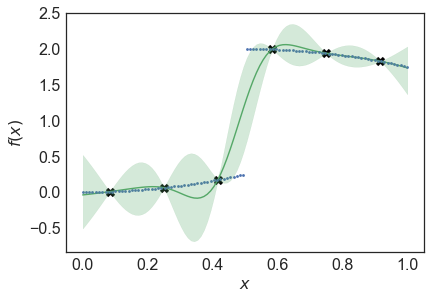

In [17]:
plt.fill_between(xnew[:, 0], y_l, y_u, color=sns.color_palette()[1], alpha=0.25, zorder=3)
plt.plot(xnew, y_m, color = sns.color_palette()[1])
plt.scatter(X, Y, marker='X', s=80, color='black')
plt.plot(xnew, Y_true, '.', color = sns.color_palette()[0])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16)

In [18]:
def visualize_l(Xgrid, M):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = sns.color_palette()[1], alpha = 0.25)

    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$ell(x)$', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return

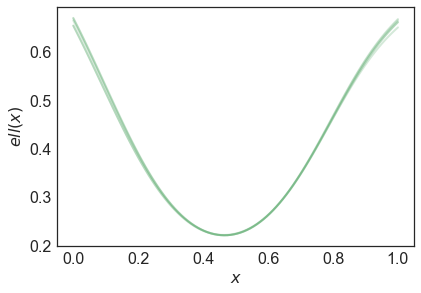

In [19]:
mini = 0
maxi = 5
for i in xrange(mini,maxi):
    visualize_l(xnew, mean_l_mat[i,:])  

In [20]:
def visualize(Xgrid, Mgrid, Vargrid):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """

    signal_std = np.sqrt(Vargrid)
 
    Stdgrid = np.sqrt(Vargrid)
    
    lower = Mgrid - 2*Stdgrid
    upper = Mgrid + 2*Stdgrid
    
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color=sns.color_palette()[1], alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = sns.color_palette()[1], alpha = 0.05)
    plt.scatter(X, Y, marker='X', s=80, color='black')
    plt.plot(xnew, Y_true, '.', color = sns.color_palette()[0])
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$f(x)$', fontsize=16)
    return

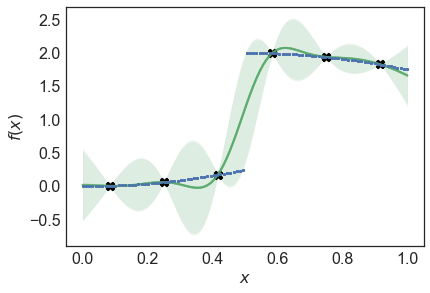

In [21]:
mini = 105
maxi = 109

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:])  

In [22]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [23]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[0][:,:]
    mean_l_mat[i,:] = mean1[0][:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [24]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [25]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [26]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = sns.color_palette()[1], alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = sns.color_palette()[1], alpha = 0.05)
    plt.xlabel('$x$', fontsize=16)
    plt.ylabel('$ell(x)$', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
   
    return

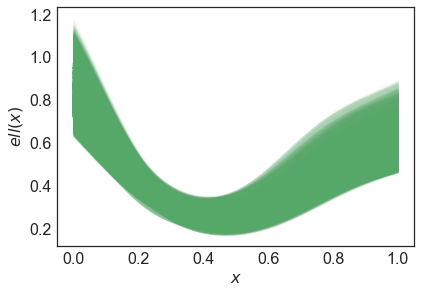

In [27]:
mini = 105
maxi = 400
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  